# LSTM RNN for GC=F prices prediction

Using a long-short term memory recurrent neural network to predics GOLD prices
retrieved from Yahoo finance.

In [18]:
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import yfinance as yf
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime


### Download GOLD data from yahoo finance

In [19]:
ticker = 'GC=F'
start = datetime(2015, 1, 1)
end = datetime.today() + timedelta(-1)
gold = yf.download(ticker, start, end)
gold

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,1186.000000,138
2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,1203.900024,470
2015-01-06,1203.500000,1220.000000,1203.500000,1219.300049,1219.300049,97
2015-01-07,1219.199951,1219.199951,1210.599976,1210.599976,1210.599976,29
2015-01-08,1207.000000,1215.699951,1206.300049,1208.400024,1208.400024,92
...,...,...,...,...,...,...
2024-04-10,2346.600098,2358.100098,2327.699951,2329.600098,2329.600098,377
2024-04-11,2341.500000,2376.300049,2330.600098,2354.800049,2354.800049,283
2024-04-12,2377.300049,2429.000000,2334.300049,2356.199951,2356.199951,584


In [20]:
X = torch.tensor(gold.to_numpy(dtype=float))
y = torch.tensor(gold['Adj Close'].to_numpy(dtype=float)).unsqueeze(dim=1)

### Define the LSTM RNN

In [21]:
class LSTMModel(nn.Module):
    """LSTM RNN model."""
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        num_layers
        ):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            num_layers=num_layers,
            dropout=0.5,
            bias=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """Classical forward pass.

        Args:
            x (_type_): _description_

        Returns:
            _type_: _description_
        """
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda()
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Only take output from the last time step
        return out


### Define training loop

In [22]:

def train(
    model,
    optimiser,
    train_data,
    test_data,
    n_epochs=100,
    loss_fun=nn.MSELoss()
):
    """
    NN training loop. Return is None, but optimises the NN.

    Args_:

        model: The NN (or other) model used for data fit.
        
        optimiser: Optimisation method for backward pass.
        
        train_data: Training set of data from DataLoader.
        
        test_data: Testing set of data from DataLoader..
        
        n_epochs: Number of iterations for the propagation.
        
        loss_fun: Loss function to minimise via back-propagation.

    Returns_:

        None.
        NN is optimised in the process, by adjusting the Arg "model".
    """
    for epoch in range(n_epochs+1):
        # train the neural network one batch at a time
        model.train()
        train_loss = 0
        for data, target in train_data:
            data, target = data.cuda(), target.cuda()
            pred_train = model(data)
            batch_train_loss = loss_fun(pred_train, target)

            train_loss += batch_train_loss.item() * data.size(0)

            optimiser.zero_grad()
            batch_train_loss.backward()
            optimiser.step()
        del data, target, pred_train

        model.eval()
        # validate for each epoch
        test_loss = 0
        with torch.no_grad():
            for data, target in test_data:
                data, target = data.cuda(), target.cuda()
                pred_test = model(data)
                batch_test_loss = loss_fun(pred_test, target)

                test_loss += batch_test_loss.item() * data.size(0)
        del data, target, pred_test

        # print epoch results
        if epoch % 20 == 0:
            print(f'Epoch {epoch}/{n_epochs};', ''*5,
                  f'    Train loss: {train_loss:.3f};', ''*5,
                  f'    Valid loss: {test_loss:.3f}')

        # setup for an early stop
        if epoch == 0:
            last_10 = torch.full((10, 1), float(test_loss)).cuda()
        else:
            last_10[epoch % 10] = test_loss

        # break condition
        condition = (
            # do at least 10 epochs
            epoch > 10
            and (
                # if the loss is stagnating
                abs((test_loss - last_10.mean())/last_10.mean()) < 0.01
                # or significantly worsening
                or test_loss > 1.2*last_10.mean()
                )
        )
        if condition:
            print(f'Break on epoch{epoch}/{n_epochs}', ''*5,
                  f'    Train loss: {train_loss:.3f};', ''*5,
                  f'    Valid loss: {test_loss:.3f}\n')
            break

### Define time prediction plots

Function plotting the time series.

In [23]:
#%%### plotting
def plot_time_predictions(
    ax, predict, target, train_predict, train_target, thresh, SUBSEQ_DAYS
    ):

    data_plot = pd.DataFrame(
        np.vstack((predict, target)).T,
        columns=['predict', 'target'],
        index = gold.index[thresh+SUBSEQ_DAYS:]
    )

    train_plot = pd.DataFrame(
        np.vstack((train_predict, train_target)).T,
        columns=['predict', 'target'],
        index = gold.index[:thresh]
    )

    ax.plot(train_plot.index, train_plot.target, 'k', label='train-target',
            linewidth=1)
    ax.plot(train_plot.index, train_plot.predict, 'r:', label='train-predict',
            linewidth=2)
    
    ax.plot(data_plot.index, data_plot.target, 'g', label='test-target',
            linewidth=1)
    ax.plot(data_plot.index, data_plot.predict, 'b:', label='test-predict',
            linewidth=2)
    ax.legend()

## MAIN LOOP

The main loop here loops through a different number of subsequent days used as
a short term memory in the LSTM.

c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/500;      Train loss: 386.674;      Valid loss: 297.159
Epoch 20/500;      Train loss: 6.784;      Valid loss: 0.989
Break on epoch32/500      Train loss: 0.678;      Valid loss: 0.388

Epoch 0/500;      Train loss: 279.177;      Valid loss: 198.987


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.094;      Valid loss: 0.738
Break on epoch32/500      Train loss: 0.896;      Valid loss: 0.502

Epoch 0/500;      Train loss: 387.852;      Valid loss: 237.334


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.064;      Valid loss: 0.542
Epoch 40/500;      Train loss: 0.845;      Valid loss: 0.303
Epoch 60/500;      Train loss: 0.729;      Valid loss: 0.221
Break on epoch66/500      Train loss: 0.710;      Valid loss: 0.221



c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/500;      Train loss: 329.244;      Valid loss: 193.806
Epoch 20/500;      Train loss: 1.100;      Valid loss: 0.337
Epoch 40/500;      Train loss: 0.852;      Valid loss: 0.263
Break on epoch46/500      Train loss: 0.824;      Valid loss: 0.263



c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/500;      Train loss: 267.287;      Valid loss: 147.788
Epoch 20/500;      Train loss: 1.079;      Valid loss: 0.379
Break on epoch39/500      Train loss: 0.833;      Valid loss: 0.284

Epoch 0/500;      Train loss: 419.577;      Valid loss: 207.444


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.111;      Valid loss: 0.375
Epoch 40/500;      Train loss: 0.931;      Valid loss: 0.322
Break on epoch40/500      Train loss: 0.931;      Valid loss: 0.322

Epoch 0/500;      Train loss: 225.054;      Valid loss: 106.788


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.051;      Valid loss: 0.352
Break on epoch30/500      Train loss: 0.889;      Valid loss: 0.326

Epoch 0/500;      Train loss: 393.500;      Valid loss: 174.216


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.059;      Valid loss: 0.360
Break on epoch35/500      Train loss: 0.931;      Valid loss: 0.340

Epoch 0/500;      Train loss: 374.619;      Valid loss: 171.134


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.172;      Valid loss: 0.429
Break on epoch24/500      Train loss: 1.091;      Valid loss: 0.433



c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/500;      Train loss: 376.878;      Valid loss: 173.310
Epoch 20/500;      Train loss: 1.126;      Valid loss: 0.458
Break on epoch31/500      Train loss: 0.988;      Valid loss: 0.378

Epoch 0/500;      Train loss: 422.656;      Valid loss: 200.649


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.144;      Valid loss: 0.386
Break on epoch29/500      Train loss: 1.000;      Valid loss: 0.392

Epoch 0/500;      Train loss: 252.679;      Valid loss: 121.719


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.983;      Valid loss: 0.351
Break on epoch28/500      Train loss: 0.893;      Valid loss: 0.358

Epoch 0/500;      Train loss: 405.529;      Valid loss: 207.392


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.138;      Valid loss: 0.485
Break on epoch31/500      Train loss: 0.980;      Valid loss: 0.384

Epoch 0/500;      Train loss: 276.416;      Valid loss: 129.276


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.041;      Valid loss: 0.388
Break on epoch27/500      Train loss: 0.909;      Valid loss: 0.367

Epoch 0/500;      Train loss: 286.941;      Valid loss: 143.680


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.969;      Valid loss: 0.386
Break on epoch30/500      Train loss: 0.846;      Valid loss: 0.325

Epoch 0/500;      Train loss: 335.739;      Valid loss: 167.404


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.129;      Valid loss: 0.429
Break on epoch30/500      Train loss: 0.928;      Valid loss: 0.366

Epoch 0/500;      Train loss: 381.075;      Valid loss: 198.207


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.213;      Valid loss: 0.480
Break on epoch33/500      Train loss: 0.945;      Valid loss: 0.359

Epoch 0/500;      Train loss: 279.668;      Valid loss: 129.409


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.025;      Valid loss: 0.353
Break on epoch28/500      Train loss: 0.899;      Valid loss: 0.346

Epoch 0/500;      Train loss: 269.920;      Valid loss: 133.942


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.971;      Valid loss: 0.339
Break on epoch27/500      Train loss: 0.894;      Valid loss: 0.352

Epoch 0/500;      Train loss: 308.193;      Valid loss: 138.796


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.009;      Valid loss: 0.400
Break on epoch30/500      Train loss: 0.894;      Valid loss: 0.344

Epoch 0/500;      Train loss: 285.488;      Valid loss: 140.159


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.050;      Valid loss: 0.377
Break on epoch28/500      Train loss: 0.926;      Valid loss: 0.391

Epoch 0/500;      Train loss: 434.146;      Valid loss: 208.693


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.072;      Valid loss: 0.356
Break on epoch32/500      Train loss: 0.920;      Valid loss: 0.355

Epoch 0/500;      Train loss: 395.668;      Valid loss: 173.440


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.017;      Valid loss: 0.383
Break on epoch38/500      Train loss: 0.857;      Valid loss: 0.310

Epoch 0/500;      Train loss: 442.510;      Valid loss: 214.799


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.133;      Valid loss: 0.428
Epoch 40/500;      Train loss: 0.892;      Valid loss: 0.329
Break on epoch40/500      Train loss: 0.892;      Valid loss: 0.329

Epoch 0/500;      Train loss: 326.297;      Valid loss: 136.667


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.022;      Valid loss: 0.410
Break on epoch34/500      Train loss: 0.846;      Valid loss: 0.305

Epoch 0/500;      Train loss: 354.455;      Valid loss: 186.742


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.044;      Valid loss: 0.354
Break on epoch32/500      Train loss: 0.856;      Valid loss: 0.316

Epoch 0/500;      Train loss: 372.418;      Valid loss: 175.435


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.021;      Valid loss: 0.377
Break on epoch34/500      Train loss: 0.860;      Valid loss: 0.335

Epoch 0/500;      Train loss: 428.172;      Valid loss: 193.339


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.030;      Valid loss: 0.376
Break on epoch30/500      Train loss: 0.934;      Valid loss: 0.355

Epoch 0/500;      Train loss: 330.509;      Valid loss: 141.812


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.987;      Valid loss: 0.342
Break on epoch26/500      Train loss: 0.909;      Valid loss: 0.354

Epoch 0/500;      Train loss: 279.931;      Valid loss: 129.692


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.000;      Valid loss: 0.343
Break on epoch28/500      Train loss: 0.896;      Valid loss: 0.346



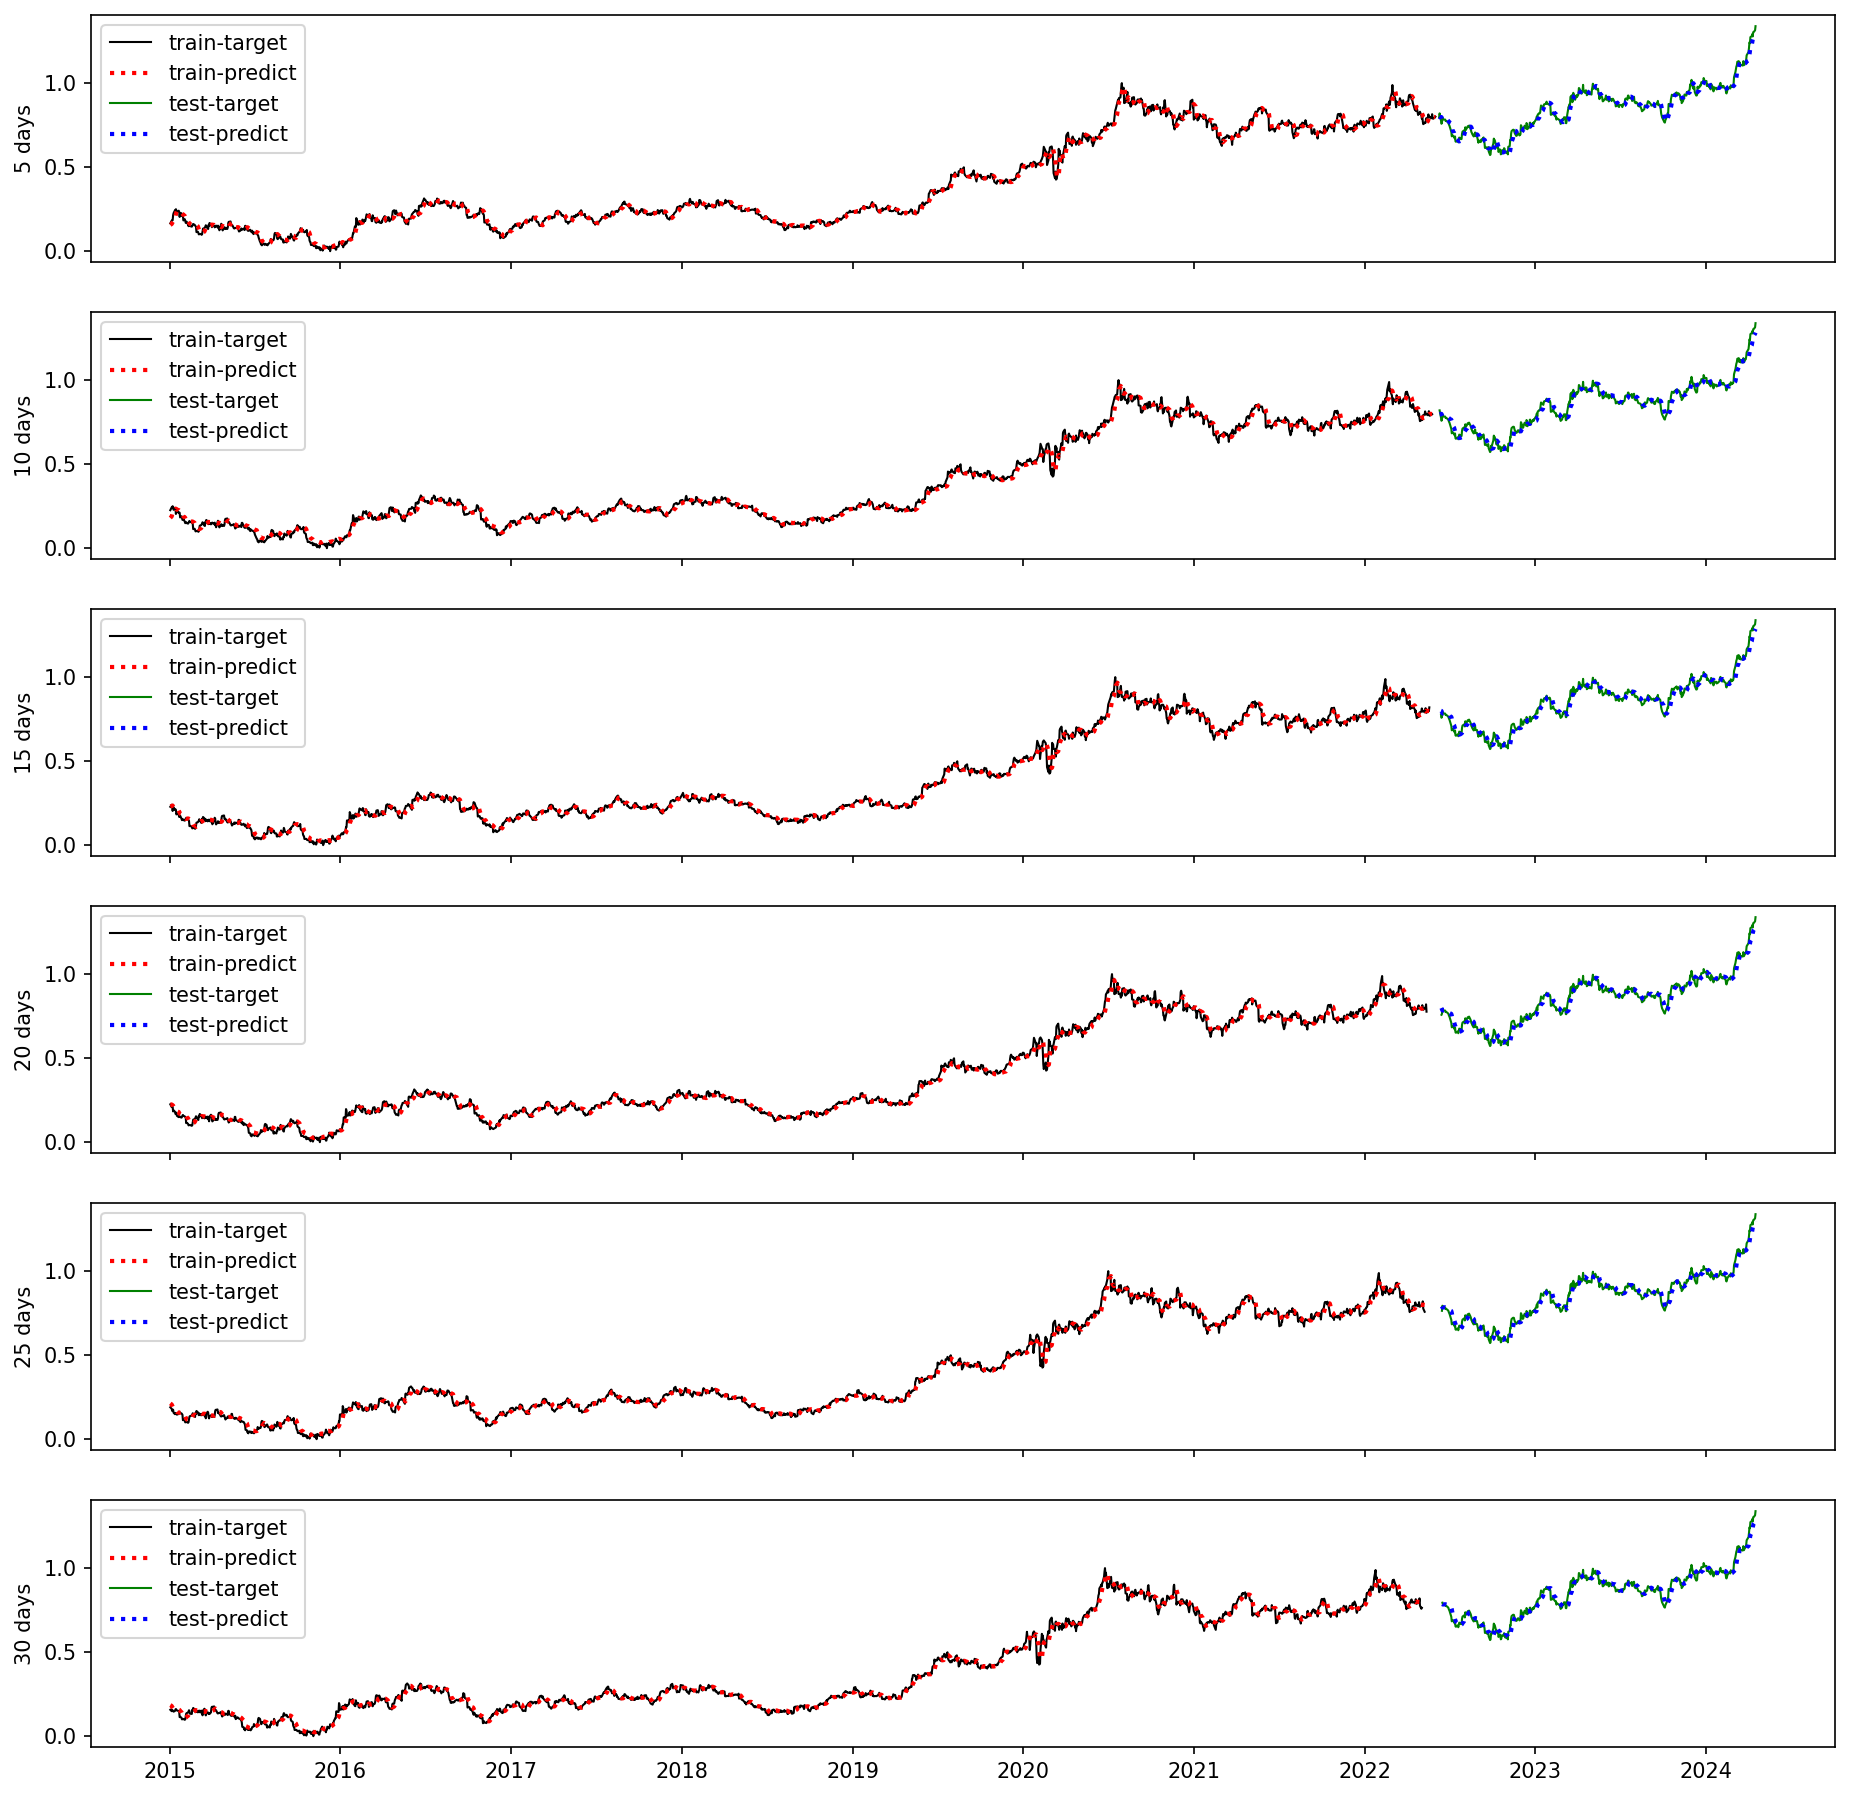

In [24]:
# dataframe to store scores in
scores = pd.DataFrame(columns=['train', 'test'])

# set up to plot time predictions for given number of days
fig, axs = plt.subplots(
    nrows=6,
    ncols=1,
    figsize=(15, 15),
    dpi=150,
    sharex=True,
    sharey=True)
# loops through different number of subsequent days to use
for SUBSEQ_DAYS in range(1, 31):
    data_len = data_len = X.shape[0] - SUBSEQ_DAYS
    num_feat = X.shape[1]
    # threshold to determine train-test splits
    thresh = int(data_len*0.8)
    
    # MinMax scaling using only data that will fall into train set
    min, _ = torch.min(X[:thresh], axis=0)
    max, _ = torch.max(X[:thresh], axis=0)

    # MinMax Scaling
    X = (X - min)/(max-min)
    y = (y-min[4])/(max[4]-min[4])
    
    # create tensors for sequenced data
    seq_X = torch.zeros(size=(data_len, SUBSEQ_DAYS, num_feat))
    seq_y = torch.zeros(size=(data_len, 1))
    # create sequences of subsequent days to feed into the LSTM
    for day in range(data_len):
        # train data from SUBSEQ_DAYS of subsequent days
        seq_X[day] = X[day:day+SUBSEQ_DAYS, :]
        # target one day in advance
        seq_y[day] = y[day+SUBSEQ_DAYS]
        
    # create train/test splits from sequenced data
    train_X, test_X = seq_X[:thresh], seq_X[thresh:]
    train_y, test_y = seq_y[:thresh], seq_y[thresh:]
    
    ### DataLoader – Dataset makes responding samples be chosen together, train loader creates batches
    train_dataset = TensorDataset(train_X, train_y)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = TensorDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

    ### instance of model and optimiser, running the train loop
    model = LSTMModel(num_feat, 200, 1, 1).cuda()
    optimiser = optim.Adam(model.parameters(), lr=1e-3)

    train(
        model=model,
        optimiser=optimiser,
        train_data=train_loader,
        test_data=test_loader,
        n_epochs=500,
        loss_fun=nn.MSELoss()
    )
    # create model predictions for train/test sets
    predict = model(test_X.cuda()).detach().cpu().flatten().numpy()
    target = test_y.flatten().numpy()

    train_predict = model(train_X.cuda()).detach().cpu().flatten().numpy()
    train_target = train_y.flatten().numpy()
    
    scores.loc[SUBSEQ_DAYS, 'train'] = r2_score(train_target, train_predict)
    scores.loc[SUBSEQ_DAYS, 'test'] = r2_score(target, predict)
    
    # plot predictions for every 5th day
    if SUBSEQ_DAYS % 5 == 0:
        plot_time_predictions(
            axs[(SUBSEQ_DAYS // 5) - 1], 
            predict, target, train_predict, train_target, thresh, SUBSEQ_DAYS
        )
        axs[(SUBSEQ_DAYS // 5) - 1].set_ylabel(f'{SUBSEQ_DAYS} days')

### plot R2 as a function of days

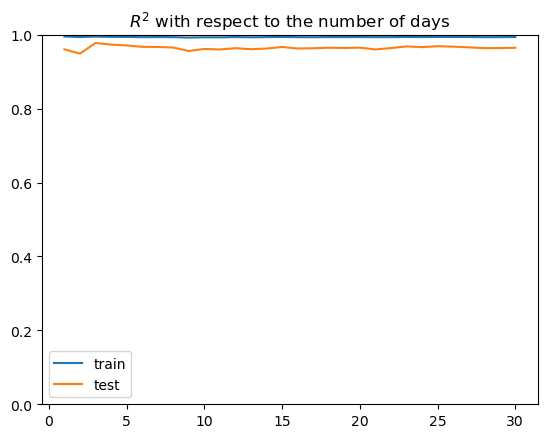

In [25]:
plt.plot(scores.train, label='train')
plt.plot(scores.test, label='test')
plt.ylim(0, 1)
plt.title('$R^2$ with respect to the number of days')
plt.legend()
plt.show()
plt.close()